In [55]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from midi_utils import plots, preprocessing, notes_counting

%reload_ext autoreload
%autoreload 2

In [56]:
# loading
dataset = load_dataset("roszcz/internship-midi-data-science", split="train")
record = dataset[0]
df = pd.DataFrame(record["notes"]).sort_values(by='start')
df = preprocessing.create_time_features(df)
df

,end,pitch,start,velocity,duration,second,minute
0,2.058438,42,1.934219,74,0.124219,1,0
1,2.990469,66,1.935573,84,1.054896,1,0
2,2.044531,30,1.948229,76,0.096302,1,0
3,2.613073,49,2.556146,77,0.056927,2,0
4,2.618333,54,2.564844,59,0.053490,2,0
...,...,...,...,...,...,...,...
88882,10856.278125,82,10856.155208,54,0.122917,10856,180
88883,10856.724115,65,10856.187188,36,0.536927,10856,180
88884,10856.875625,70,10856.732500,34,0.143125,10856,180
88885,10856.849063,89,10856.750156,57,0.098906,10856,180


# Number of notes playerd per second in a record

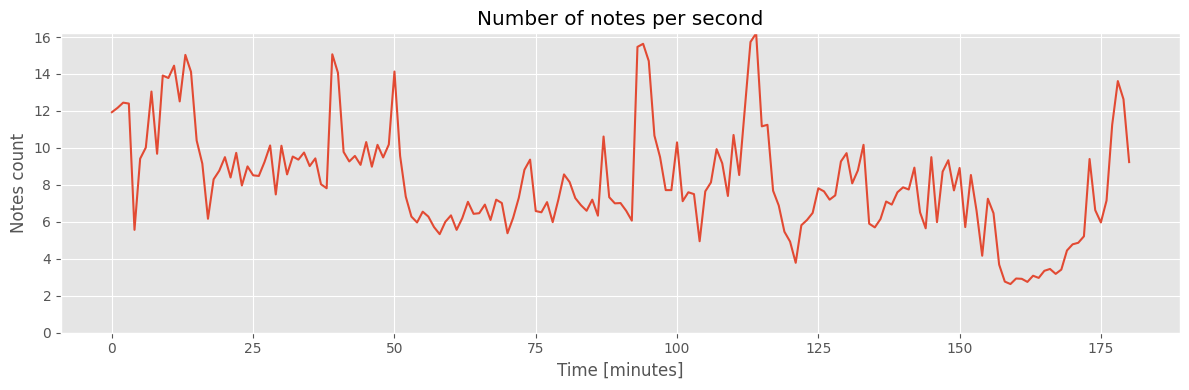

In [57]:
plots.plot_record_speed(df)

# Number of notes pressed at the same time

## Looking ahead

In [67]:
record_lookahead = notes_counting.count_notes_lookahead(df, filter_count = 2)
grouped_lookahead = notes_counting.aggregate_counts_by_time(record_lookahead, count_col='len_overlapp', time_col='minute')
record_lookahead2 = notes_counting.count_notes_lookahead(df, filter_count = 3)
grouped_lookahead2 = notes_counting.aggregate_counts_by_time(record_lookahead2, count_col='len_overlapp', time_col='minute')

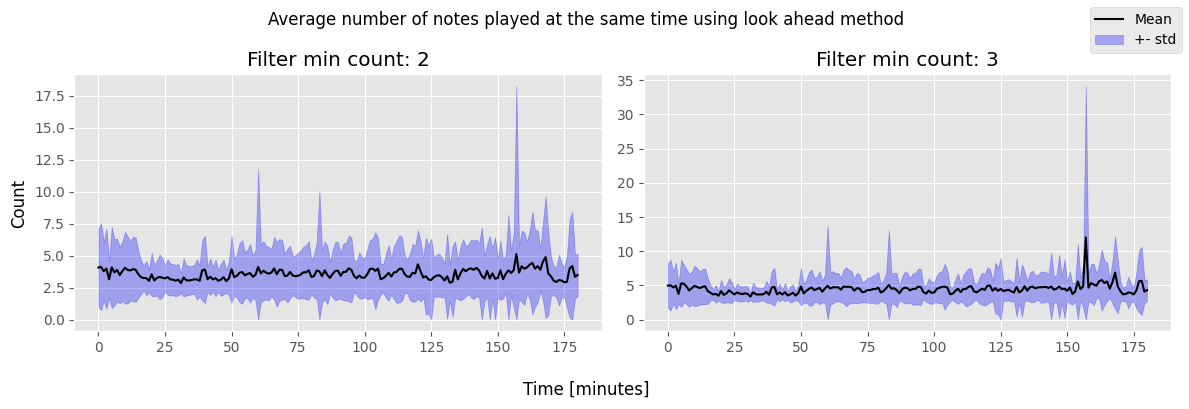

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plots.plot_aggregated_notes(ax[0], grouped_lookahead, f'Filter min count: {2}')
plots.plot_aggregated_notes(ax[1], grouped_lookahead2, f'Filter min count: {3}')

fig.supxlabel('Time [minutes]'), fig.supylabel('Count')
fig.suptitle('Average number of notes played at the same time using look ahead method')
fig.legend(['Mean', '+- std'])
fig.tight_layout()

- I feel like value 2 is just okay, it filters alot of lower counts that dont contribute 
- the peak around 150 min, mayby the arists is pressing the keys very slowly, so it catches the long sequences quite well. It seems reasonable as it catches the drop in dynamics at that moment.
- I wonder if its too smooth

## Grouping notes in fixed intervals

In [104]:
data_intervals = []
intervals = [0.3, 0.5, 0.7, 1]
for idx, interval in enumerate(intervals):
    occurences = notes_counting.count_notes_fixed_interval(df, interval)
    grouped_occurences = notes_counting.aggregate_counts_by_time(occurences, 'notes_played', 'minute')
    data_intervals.append(grouped_occurences.copy())

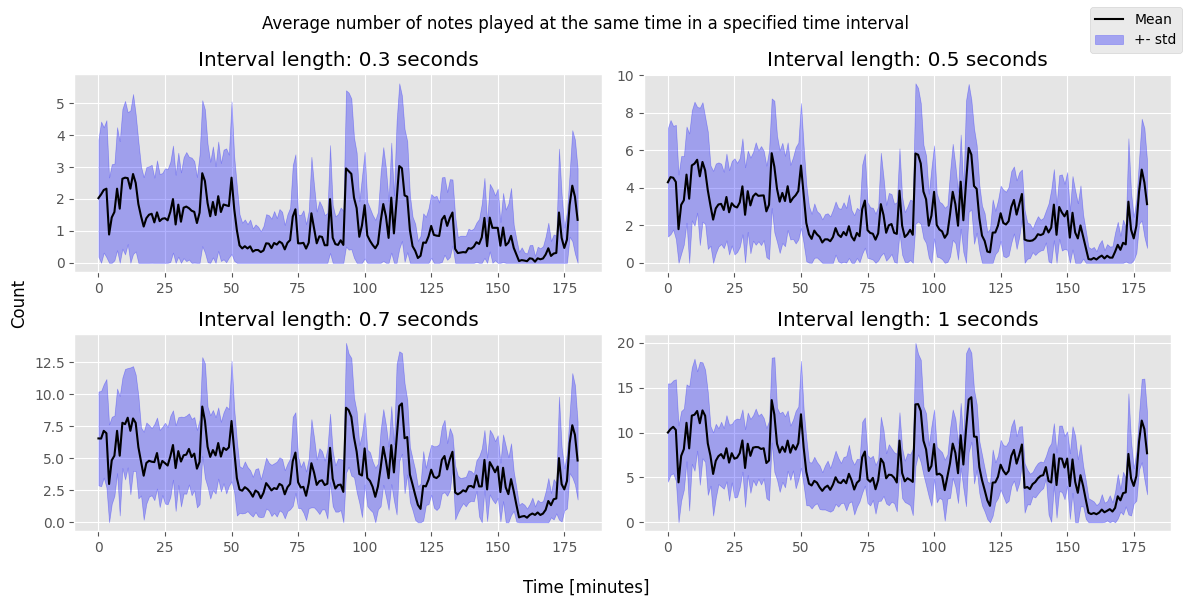

In [106]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()

for idx, data in enumerate(data_intervals):
    plots.plot_aggregated_notes(ax[idx], data, f'Interval length: {intervals[idx]} seconds')

fig.supxlabel('Time [minutes]'), fig.supylabel('Count')
fig.suptitle('Average number of notes played at the same time in a specified time interval')
fig.legend(['Mean', '+- std'])
fig.tight_layout()

- Which time interval is appriopriate? I tried some smaller and greater values outside of these four, but 0.5-0.7 seems okay. I don't actually know how fast pianists are playing to choose proper value, but this method represents the dynamics better.
- One problem I find with this is that it seems more like notes/sec with extra steps (the chart is almost the same), it doesnt respect the distance between played sequences.